In [1]:
import retirement_api as rt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1.0 Case

An individual provides a sum of money to PM. Essential Goal is to have 20k for 20 years income starting 10 years from now. Aspirational goal is 50k.

For the sake of case being interesting let's set initial sum of money given by investor in such way that 25k would be achieved by investing in risk-free.

Assume that  inflation is on average 2%.

Hence, the payments of 25k will instead be:

In [2]:
payments_of_25k = rt.generate_equal_consumption_streams(cash_flows_decumulation=-25000, inflation_rate=0.02)
payments_of_25k['inflation_adjusted_CFs']

1         0.000000
2         0.000000
3         0.000000
4         0.000000
5         0.000000
6         0.000000
7         0.000000
8         0.000000
9         0.000000
10        0.000000
11   -31084.357710
12   -31706.044864
13   -32340.165761
14   -32986.969077
15   -33646.708458
16   -34319.642627
17   -35006.035480
18   -35706.156189
19   -36420.279313
20   -37148.684899
21   -37891.658597
22   -38649.491769
23   -39422.481605
24   -40210.931237
25   -41015.149862
26   -41835.452859
27   -42672.161916
28   -43525.605154
29   -44396.117257
30   -45284.039603
Name: inflation_adjusted_CFs, dtype: float64

Their PV under condition of risk-free being on average 3% at time 0 is:

In [3]:
# find proper discounting factor
payments_of_25k['discounting_factor'] = (1-0.03)**payments_of_25k.index

# then find their discounted values to find the actual goal
sum_at_inception_25k = np.sum(payments_of_25k['discounting_factor'] * payments_of_25k['inflation_adjusted_CFs']*-1)
sum_at_inception_25k.round(2)

402637.02

Full table would look like this:

In [4]:
#payments_of_25k

This is the sum of money at inception that would allow to achieve the 25k goal with just investment in 3% bonds (assuming interest rates do not move)

Hence, the goal after fiest 10 years is

In [5]:
goal = (sum_at_inception_25k*(1.03**10)).round(2)
goal

541110.49

This is the goal that will provide easy consumtion of 25k. **This is a meaningful starting value**

But actual goals are EG and AG. AG gives consumtion of 50k and EG gives consumption of 20k. Let's find them as the exact numbers to achieve in the next 10 years.

In [6]:
EG = rt.generate_equal_consumption_streams(cash_flows_decumulation=-20000)
EG['discounting_factor'] = (1-0.03)**EG.index
EG_at_inception = np.sum(EG['discounting_factor'] * EG['inflation_adjusted_CFs']*-1)

AG = rt.generate_equal_consumption_streams(cash_flows_decumulation=-50000)
AG['discounting_factor'] = (1-0.03)**AG.index
AG_at_inception = np.sum(AG['discounting_factor'] * AG['inflation_adjusted_CFs']*-1)

We would have need that much money at inception to reach EG by just investing under constant 3% rate:

In [7]:
EG_at_inception.round(0)

322110.0

And that much money for aspirational goal:

In [8]:
AG_at_inception.round(0)

805274.0

hence, the goals after 10 years would be:

In [9]:
(EG_at_inception*1.03**10).round(0),(AG_at_inception*1.03**10).round(0)

(432888.0, 1082221.0)

Note that if at any moment of PV of AG is achieved a rational PM would stop investing in PSP and put all money into risk-free.
At the same time the value of EG can never fall below PV of initial EG sum. Let's construct this situation.

In [10]:
tresholds = pd.DataFrame(index = np.arange(0,11,1))
tresholds['risk_free_return'] = 1.03**(tresholds.index)
tresholds['AG_treshold'] = AG_at_inception * tresholds['risk_free_return']
tresholds['EG_treshold'] = EG_at_inception * tresholds['risk_free_return']
tresholds

,risk_free_return,AG_treshold,EG_treshold
0,1.000000,8.052740e+05,322109.618328
1,1.030000,8.294323e+05,331772.906878
2,1.060900,8.543152e+05,341726.094084
3,1.092727,8.799447e+05,351977.876907
4,1.125509,9.063430e+05,362537.213214
5,1.159274,9.335333e+05,373413.329610
6,1.194052,9.615393e+05,384615.729499
7,1.229874,9.903855e+05,396154.201384
8,1.266770,1.020097e+06,408038.827425
9,1.304773,1.050700e+06,420279.992248


Plotting the trsholds:

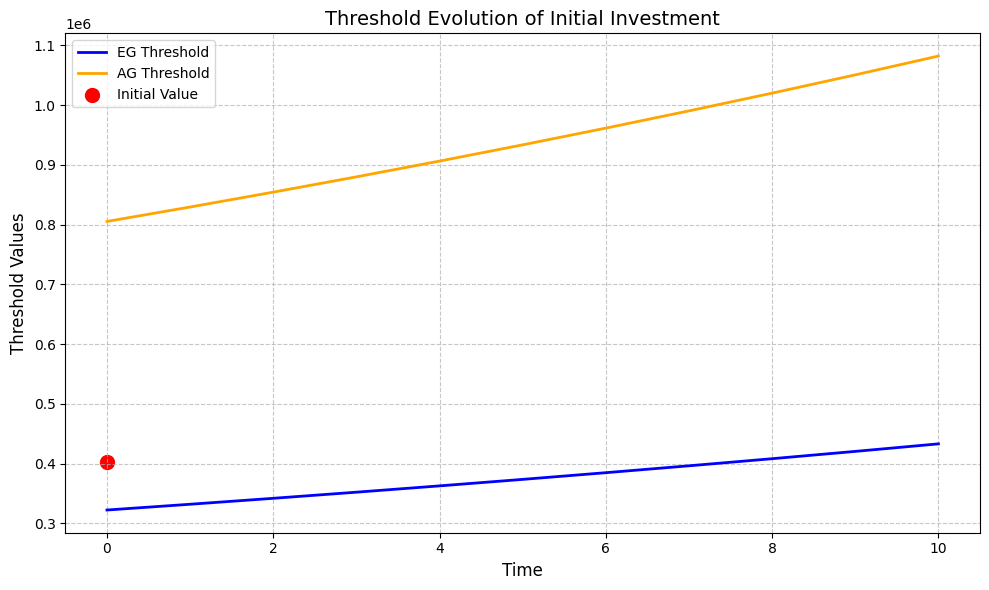

In [11]:
plt.figure(figsize=(10, 6))

# Improved line plots
plt.plot(tresholds.index, tresholds['EG_treshold'], label="EG Threshold", linewidth=2, color='blue')
plt.plot(tresholds.index, tresholds['AG_treshold'], label="AG Threshold", linewidth=2, color='orange')

# Improved scatter plot with better positioning
plt.scatter(0, sum_at_inception_25k.round(2), color='red', s=100, label="Initial Value")

# Labels and title
plt.xlabel("Time", fontsize=12)
plt.ylabel("Threshold Values", fontsize=12)
plt.title("Threshold Evolution of Initial Investment", fontsize=14)

# Adding grid, legend, and better layout
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()

# Display the plot
plt.show()

# 2.0 Market simulation

In [12]:
initial_sum_of_money = sum_at_inception_25k.round(2)

In [13]:
# Parameters
S0 = 1.0              # asset price
T = 10                 # time in years
N = 252*T              # number of time steps in simulation
M = 10                  # number of simulated paths
seed = 123              # simulation seed

Simulate stock market and intereset rates

In [14]:
S_p, v_p, sr_p, r_p = rt.market_simulation(T, N, M,seed,S0)
zc_bond_3y_prices = rt.vasicek_zcb_price(r_p, tau=3)
bond_3y_index = rt.deduce_bond_index(zc_bond_3y_prices, r_p, dt = T/N, initial_investment=1)

## 2.1 Assume all money is invested in stock

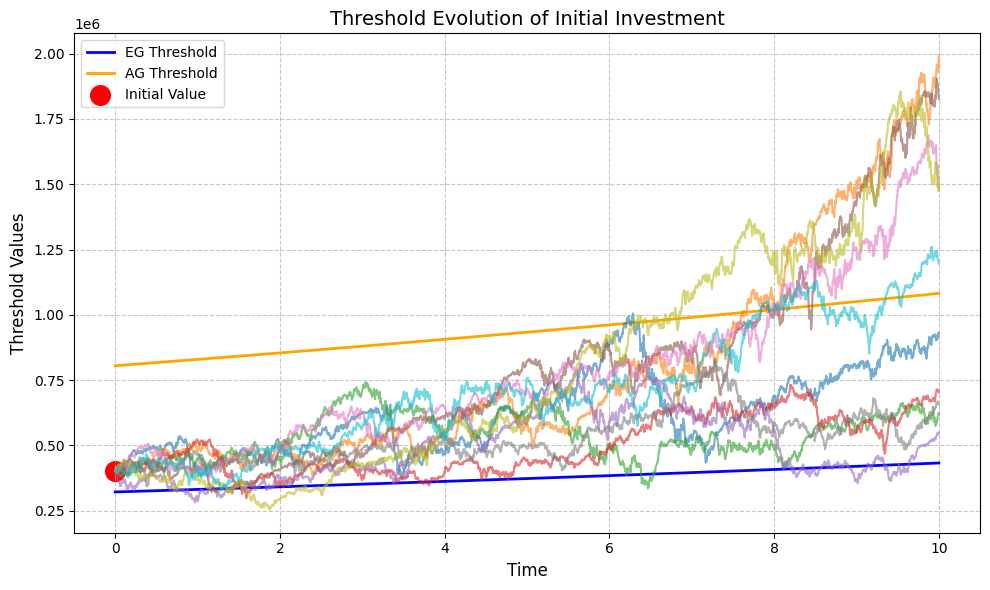

In [15]:
plt.figure(figsize=(10, 6))

# Improved line plots
plt.plot(tresholds.index, tresholds['EG_treshold'], label="EG Threshold", linewidth=2, color='blue')
plt.plot(tresholds.index, tresholds['AG_treshold'], label="AG Threshold", linewidth=2, color='orange')
plt.plot(initial_sum_of_money*S_p, alpha = 0.6)

# Improved scatter plot with better positioning
plt.scatter(0, sum_at_inception_25k.round(2), color='red', s=200, label="Initial Value")

# Labels and title
plt.xlabel("Time", fontsize=12)
plt.ylabel("Threshold Values", fontsize=12)
plt.title("Threshold Evolution of Initial Investment", fontsize=14)

# Adding grid, legend, and better layout
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()

# Display the plot
plt.show()

Stock already beats the market in any case

But the problem is that the actual EG and AG depend not on 3% plain rate, but on risk-free rate that is also stochastically set

## 2.2 Assume all money is invested in bond index

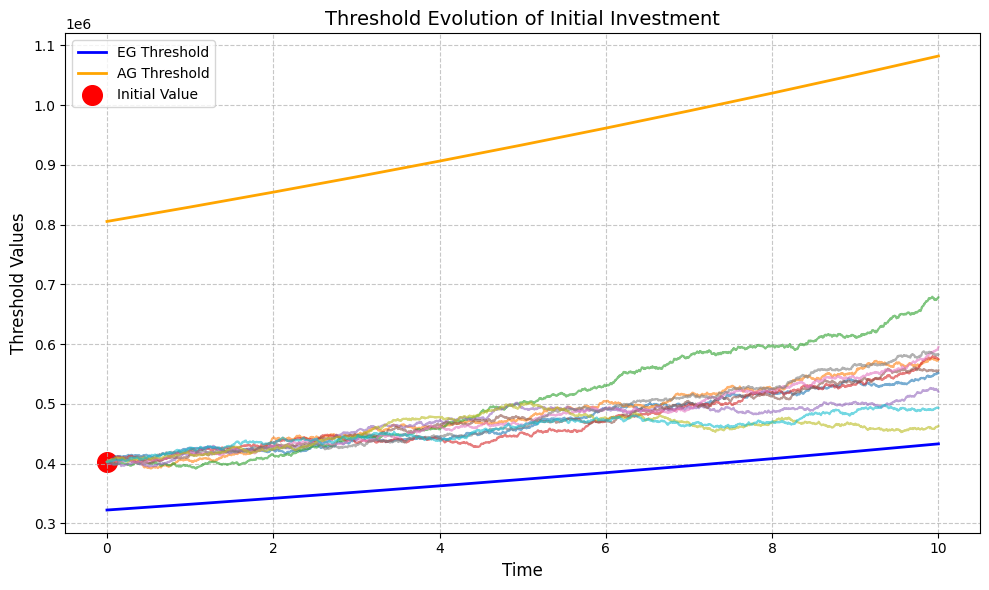

In [16]:
plt.figure(figsize=(10, 6))

# Improved line plots
plt.plot(tresholds.index, tresholds['EG_treshold'], label="EG Threshold", linewidth=2, color='blue')
plt.plot(tresholds.index, tresholds['AG_treshold'], label="AG Threshold", linewidth=2, color='orange')
plt.plot(initial_sum_of_money*bond_3y_index, alpha = 0.6)

# Improved scatter plot with better positioning
plt.scatter(0, sum_at_inception_25k.round(2), color='red', s=200, label="Initial Value")

# Labels and title
plt.xlabel("Time", fontsize=12)
plt.ylabel("Threshold Values", fontsize=12)
plt.title("Threshold Evolution of Initial Investment", fontsize=14)

# Adding grid, legend, and better layout
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()

# Display the plot
plt.show()

The bond index does not anything on to reach the objective

## 2.3.1 Equal weighted portfolio of stocks and bonds

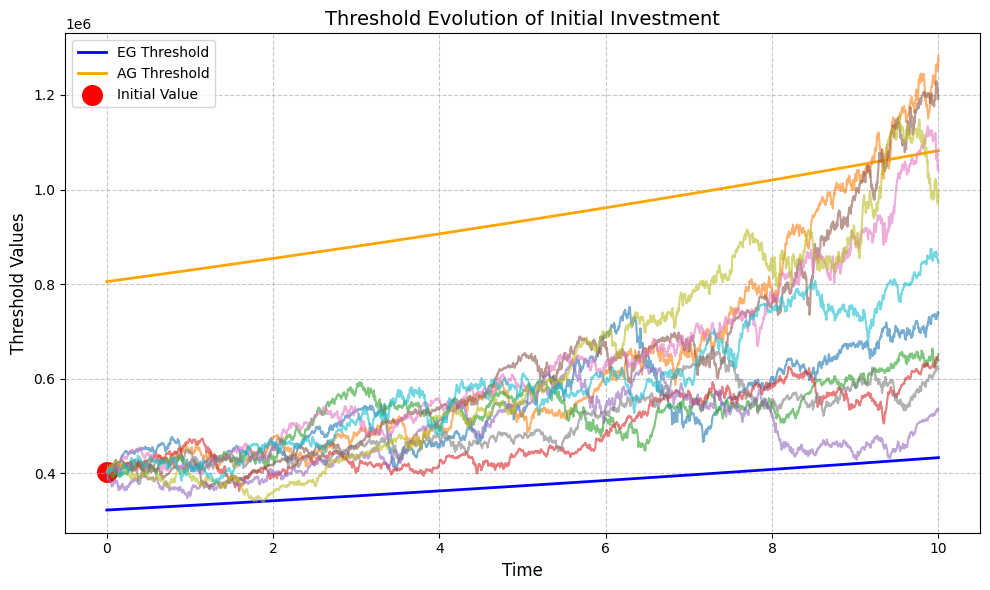

In [17]:
plt.figure(figsize=(10, 6))

# Improved line plots
plt.plot(tresholds.index, tresholds['EG_treshold'], label="EG Threshold", linewidth=2, color='blue')
plt.plot(tresholds.index, tresholds['AG_treshold'], label="AG Threshold", linewidth=2, color='orange')
plt.plot(initial_sum_of_money*(0.5*bond_3y_index+0.5*S_p), alpha = 0.6)

# Improved scatter plot with better positioning
plt.scatter(0, sum_at_inception_25k.round(2), color='red', s=200, label="Initial Value")

# Labels and title
plt.xlabel("Time", fontsize=12)
plt.ylabel("Threshold Values", fontsize=12)
plt.title("Threshold Evolution of Initial Investment", fontsize=14)

# Adding grid, legend, and better layout
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()

# Display the plot
plt.show()

The strategy became better. It does not breach the floor while achieving the ceiling

# 2.3.2 Success simulation of balaced portfolio of a bond and a stock

Let's simulate 10000 scenarios

In [18]:
M = 10000                  # number of simulated paths
S_p, v_p, sr_p, r_p = rt.market_simulation(T, N, M,seed,S0)
zc_bond_3y_prices = rt.vasicek_zcb_price(r_p, tau=3)
bond_3y_index = rt.deduce_bond_index(zc_bond_3y_prices, r_p, dt = T/N, initial_investment=1)

# 2.3.3 Balanced Fund Performance

In [29]:
def balanced_portolio(stock_returns, bond_returns, stocks_weight):
    if stocks_weight<0 or stocks_weight>1:
        raise ValueError('stocks_weight should be between 0 and 1')
    return stock_returns*stocks_weight + bond_returns*(1-stocks_weight)

In [47]:
df_balanced_portfolio_returns = pd.DataFrame(columns = ['% invested in stocks', 'prob. EG', 'prob.AG'])

for stock_weight in np.arange(0,1.1,0.1):
    portfolio_returns = balanced_portolio(S_p, bond_3y_index, stock_weight)

    df_balanced_portfolio_returns.loc[stock_weight,'% invested in stocks'] = stock_weight
    df_balanced_portfolio_returns.loc[stock_weight,'prob. EG'] = np.mean(portfolio_returns.iloc[-1,:]*initial_sum_of_money > tresholds['EG_treshold'][10])
    df_balanced_portfolio_returns.loc[stock_weight,'prob.AG'] = np.mean(portfolio_returns.iloc[-1,:]*initial_sum_of_money > tresholds['AG_treshold'][10])

df_balanced_portfolio_returns

,% invested in stocks,prob. EG,prob.AG
0.0,0.0,0.9955,0.0
0.1,0.1,0.9967,0.0045
0.2,0.2,0.991,0.0491
0.3,0.3,0.9777,0.1297
0.4,0.4,0.9628,0.2022
0.5,0.5,0.9468,0.2724
0.6,0.6,0.9331,0.3331
0.7,0.7,0.9218,0.3813
0.8,0.8,0.9131,0.4233
0.9,0.9,0.9051,0.4582
